# Lab3: Frequent Pattern Mining - Bread Basket
## 1 About Dataset

![](image/Basket.png)

### 1.1 Context

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 20507 entries, over 9000 transactions, and 4 columns.

### 1.2 Content

The dataset has transactions of customers who ordered different items from this bakery online and the time period of the data is from 26-01-11 to 27-12-03. The columns in this dataset are:

- Transaction: Transaction id which is unique for each order

- Item: List of items to be ordered/placed by customer

- date_time: Date and time of the transaction. format: dd-mm-yyyy hh:mm

- period_day: Which period of a day when customer placed ordered

- weekday_weekend: Is the day is weekend (sat or sun) or weekday

## 2 Data Preprocessing
Set up coding environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")
print("Setup Complete")

Setup Complete


Load and examine the data

In [2]:
df = pd.read_csv('data/bread basket.csv')
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [3]:
df.describe()

,Transaction
count,20507.000000
mean,4976.202370
std,2796.203001
min,1.000000
25%,2552.000000
50%,5137.000000
75%,7357.000000
max,9684.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


We can conclude from the table above that there is no missing value in the dataset.

In [5]:
df['Transaction'].nunique()

9465

We can find that the dataset contains 9465 unique transactions.

In [6]:
df['Item'].value_counts()

Coffee            5471
Bread             3325
Tea               1435
Cake              1025
Pastry             856
                  ... 
Bacon                1
Gift voucher         1
Olum & polenta       1
Raw bars             1
Polenta              1
Name: Item, Length: 94, dtype: int64

We can also find that there are 94 different items in the dataset.

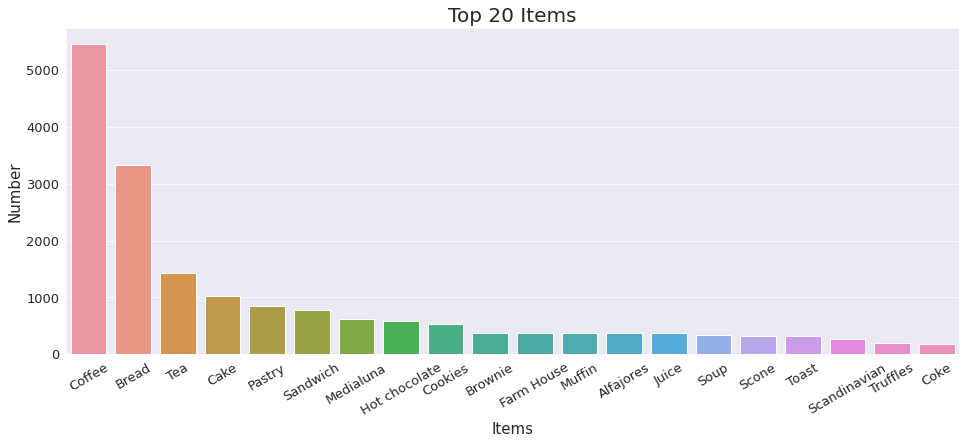

In [7]:
plt.figure(figsize=(16,6))
sns.barplot(x = df.Item.value_counts().head(20).index, 
            y = df.Item.value_counts().head(20).values)
plt.xlabel('Items', size=15)
plt.xticks(rotation=30, size=13)
plt.ylabel('Number', size=15)
plt.yticks(size=13)
plt.title('Top 20 Items', size=20)
plt.show()

From the charts above we can roughly see that the most purchased items are coffee, bread, tea, cake pastry, and sandwich. We can also consider and set a threshold for support based on the above chart.

In [8]:
# dataset = []
# for i in df['Transaction'].unique():
#     dataset.append(df[df['Transaction'] == i]['Item'].unique().tolist())
# np.save('data/dataset.npy', dataset)
dataset = np.load('data/dataset.npy', allow_pickle=True)
dataset

array([list(['Bread']), list(['Scandinavian']),
       list(['Hot chocolate', 'Jam', 'Cookies']), ...,
       list(['Muffin', 'Tacos/Fajita', 'Coffee', 'Tea']),
       list(['Coffee', 'Pastry']), list(['Smoothies'])], dtype=object)

## 3 Apriori Algorithm

### 3.1 Apriori algorithm principle

Apriori algorithm is a frequent itemset mining algorithm. It is a combination of the ideas of association rule learning and pattern discovery.

Apriori algorithm  follows the Apriori property: all non-empty subsets of frequent itemsets must also be frequent itemsets.

Apriori uses an iterative method of layer-by-layer search, which means frequent k-itemset is used to construct frequent (k+1)-itemsets.

The algorithm process is as follows:

- Set k = 1. Scan the dataset, accumulate the counts for each item, and collect the items that satisfy the minimum support to build a frequent 1-itemset L1. 

- Take the union of each two items in Lk. If the number of elements in the result is equal to k+1 and satisfy the minimum support condition, add the result itemset to frequent (k+1)-itemset.

- Set k = k+1. Repeat the previous step until the number of elements in frequent (k+1)-itemset is 0.

### 3.2 Apriori algorithm implementation

In [9]:
class Apriori(object):
    def __init__(self, data, min_sup=2):
        self.data = data
        self.min_sup = min_sup
        self.support_hash = {}

    def pruning(self, L):
        '''剪枝'''
        L_prune = []
        for item in L:
            support = sum(1 for transaction in self.data if item.issubset(transaction)) / len(self.data) * 100
            if support >= self.min_sup:
                L_prune.append(item)
                self.support_hash[item] = support
        return L_prune
    
    def frequent_itemsets_L1(self):
        '''创建单项频繁项集L1'''
        C1 = []  
        for transaction in self.data:  
            for item in transaction:  
                if [item] not in C1: 
                    C1.append([item])  
        C1 = [frozenset(item) for item in C1]
        L1 = self.pruning(C1)
        L1.sort()
        return L1
    
    def frequent_itemsets_Lk(self, L):
        '''根据频繁项集Lk-1创建频繁项集Lk'''
        Ck = []
        k = len(L[0])
        for itemset1 in L:
            for itemset2 in L:
                if itemset1 != itemset2:
                    union = itemset1 | itemset2
                    if len(union) == k+1 and union not in Ck:
                        Ck.append(union)
        Ck = [frozenset(item) for item in Ck]
        Lk = self.pruning(Ck)
        Lk.sort()
        return Lk

    def apriori(self):
        '''Apriori算法'''
        L = []
        Lk = self.frequent_itemsets_L1()
        while len(Lk) > 0:
            L += Lk
            Lk = self.frequent_itemsets_Lk(Lk)
        return L

    def association_rules(self, L, min_conf=50):
        '''生成强关联规则'''
        rules = []
        for item1 in L:
            for item2 in L:
                if item1 != item2 and item1.issubset(item2):
                        confidence = self.support_hash[item2] / self.support_hash[item1] * 100
                        if confidence >= min_conf:
                            rules.append((item1, item2 - item1, confidence))
        return rules

### 3.3 Create frequent itemsets

In [10]:
ap1 = Apriori(dataset, min_sup=1)
L1 = ap1.apriori()
L1

[frozenset({'Bread'}),
 frozenset({'Scandinavian'}),
 frozenset({'Hot chocolate'}),
 frozenset({'Jam'}),
 frozenset({'Cookies'}),
 frozenset({'Muffin'}),
 frozenset({'Coffee'}),
 frozenset({'Pastry'}),
 frozenset({'Medialuna'}),
 frozenset({'Tea'}),
 frozenset({'Mineral water'}),
 frozenset({'Farm House'}),
 frozenset({'Fudge'}),
 frozenset({'Juice'}),
 frozenset({'Hearty & Seasonal'}),
 frozenset({'Soup'}),
 frozenset({'Cake'}),
 frozenset({'Coke'}),
 frozenset({'Sandwich'}),
 frozenset({'Alfajores'}),
 frozenset({'Brownie'}),
 frozenset({'Truffles'}),
 frozenset({'Jammie Dodgers'}),
 frozenset({'Tiffin'}),
 frozenset({'Toast'}),
 frozenset({'Scone'}),
 frozenset({'Salad'}),
 frozenset({'Chicken Stew'}),
 frozenset({'Spanish Brunch'}),
 frozenset({'Baguette'}),
 frozenset({'Bread', 'Hot chocolate'}),
 frozenset({'Bread', 'Cookies'}),
 frozenset({'Bread', 'Coffee'}),
 frozenset({'Bread', 'Pastry'}),
 frozenset({'Bread', 'Medialuna'}),
 frozenset({'Bread', 'Tea'}),
 frozenset({'Bread', 

From the table above we can see that when the minimum support is 1%, the algorithm generates 61 frequent items, including frequent 1-itemset with 30 items, frequent 2-itemset with 28 items and frequent 3-itemset with 3 items.

In [11]:
ap5 = Apriori(dataset, min_sup=5)
L5 = ap5.apriori()
L5

[frozenset({'Bread'}),
 frozenset({'Hot chocolate'}),
 frozenset({'Cookies'}),
 frozenset({'Coffee'}),
 frozenset({'Pastry'}),
 frozenset({'Medialuna'}),
 frozenset({'Tea'}),
 frozenset({'Cake'}),
 frozenset({'Sandwich'}),
 frozenset({'Bread', 'Coffee'}),
 frozenset({'Cake', 'Coffee'})]

From the table above we can see that when the minimum support is 5%, the algorithm generates 11 frequent items, including frequent 1-itemset with 9 items and frequent 2-itemset with 2 items.

In [12]:
ap10 = Apriori(dataset, min_sup=10)
L10 = ap10.apriori()
L10

[frozenset({'Bread'}),
 frozenset({'Coffee'}),
 frozenset({'Tea'}),
 frozenset({'Cake'})]

From the table above we can see that when the minimum support is 10%, the algorithm generates 4 frequent items and they are all in frequent 1-itemset.

### 3.4 Generate association rules

In [13]:
ap1.association_rules(L1, min_conf=70)

[(frozenset({'Toast'}), frozenset({'Coffee'}), 70.44025157232706)]

From the table above we can see that when the minimum support is 1% and the minimum confidence is 70%, the algorithm generates only one strong association rule.

In [14]:
ap1.association_rules(L1, min_conf=50)

[(frozenset({'Hot chocolate'}), frozenset({'Coffee'}), 50.724637681159415),
 (frozenset({'Cookies'}), frozenset({'Coffee'}), 51.844660194174764),
 (frozenset({'Pastry'}), frozenset({'Coffee'}), 55.21472392638037),
 (frozenset({'Medialuna'}), frozenset({'Coffee'}), 56.92307692307692),
 (frozenset({'Juice'}), frozenset({'Coffee'}), 53.42465753424658),
 (frozenset({'Cake'}), frozenset({'Coffee'}), 52.695829094608335),
 (frozenset({'Sandwich'}), frozenset({'Coffee'}), 53.23529411764706),
 (frozenset({'Alfajores'}), frozenset({'Coffee'}), 54.06976744186047),
 (frozenset({'Toast'}), frozenset({'Coffee'}), 70.44025157232706),
 (frozenset({'Scone'}), frozenset({'Coffee'}), 52.29357798165138),
 (frozenset({'Spanish Brunch'}), frozenset({'Coffee'}), 59.88372093023256)]

From the table above we can see that when the minimum support is 1% and the minimum confidence is 50%, the algorithm generates 11 strong association rules.

In [15]:
ap1.association_rules(L1, min_conf=25)

[(frozenset({'Bread'}), frozenset({'Coffee'}), 27.51049402647724),
 (frozenset({'Hot chocolate'}), frozenset({'Coffee'}), 50.724637681159415),
 (frozenset({'Cookies'}), frozenset({'Bread'}), 26.601941747572816),
 (frozenset({'Cookies'}), frozenset({'Coffee'}), 51.844660194174764),
 (frozenset({'Muffin'}), frozenset({'Coffee'}), 48.9010989010989),
 (frozenset({'Pastry'}), frozenset({'Bread'}), 33.86503067484663),
 (frozenset({'Pastry'}), frozenset({'Coffee'}), 55.21472392638037),
 (frozenset({'Medialuna'}), frozenset({'Bread'}), 27.350427350427353),
 (frozenset({'Medialuna'}), frozenset({'Coffee'}), 56.92307692307692),
 (frozenset({'Tea'}), frozenset({'Coffee'}), 34.96296296296296),
 (frozenset({'Juice'}), frozenset({'Coffee'}), 53.42465753424658),
 (frozenset({'Soup'}), frozenset({'Coffee'}), 46.012269938650306),
 (frozenset({'Cake'}), frozenset({'Coffee'}), 52.695829094608335),
 (frozenset({'Sandwich'}), frozenset({'Coffee'}), 53.23529411764706),
 (frozenset({'Alfajores'}), frozenset(

From the table above we can see that when the minimum support is 1% and the minimum confidence is 25%, the algorithm generates 24 strong association rules.

In [16]:
ap5.association_rules(L5, min_conf=50)

[(frozenset({'Cake'}), frozenset({'Coffee'}), 52.695829094608335)]

From the table above we can see that when the minimum support is 5% and the minimum confidence is 50%, the algorithm generates 1 strong association rules.

In [17]:
ap5.association_rules(L5, min_conf=10)

[(frozenset({'Bread'}), frozenset({'Coffee'}), 27.51049402647724),
 (frozenset({'Coffee'}), frozenset({'Bread'}), 18.81625441696113),
 (frozenset({'Coffee'}), frozenset({'Cake'}), 11.43992932862191),
 (frozenset({'Cake'}), frozenset({'Coffee'}), 52.695829094608335)]

From the table above we can see that when the minimum support is 5% and the minimum confidence is 10%, the algorithm generates 4 strong association rules.

In [18]:
ap10.association_rules(L10, min_conf=0)

[]

From the table above we can see that when the minimum support is 10%, the algorithm generates no strong association rules at all.